In [1]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
from dotenv import dotenv_values

from sqlalchemy import create_engine, types
from sqlalchemy import text # to be able to pass string

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from dotenv import dotenv_values

config = dotenv_values()

# define variables for the login
pg_user = config['POSTGRES_USER']  # align the key label with your .env file !
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']


url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

engine = create_engine(url, echo=False)

my_schema = 'capstone_barstov_industries'

with engine.begin() as conn: 
    result = conn.execute(text(f'SET search_path TO {my_schema};'))

with engine.begin() as conn: # Done with echo=False
    result = conn.execute(text(f'''
                               SELECT * FROM product_analysis; 
                                '''))
    data = result.all()

### Let's create a dataframe out of that
product_analysis = pd.DataFrame(data)

In [3]:
product_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2423211 entries, 0 to 2423210
Data columns (total 19 columns):
 #   Column              Dtype  
---  ------              -----  
 0   column1             int64  
 1   article_id          int64  
 2   product_type_no     int64  
 3   product_type_name   object 
 4   product_group_name  object 
 5   colour_group_code   int64  
 6   colour_group_name   object 
 7   index_code          object 
 8   index_name          object 
 9   section_name        object 
 10  garment_group_no    int64  
 11  unique_customers    int64  
 12  total_sales         float64
 13  average_price       float64
 14  month               object 
 15  week                object 
 16  units_sold          int64  
 17  avg_customer_age    float64
 18  postal_code         object 
dtypes: float64(3), int64(7), object(9)
memory usage: 351.3+ MB


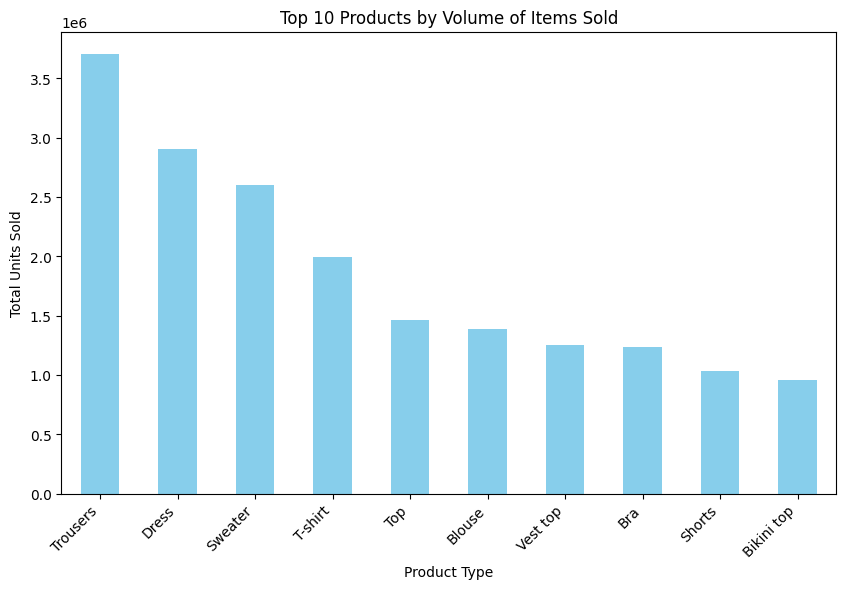

In [4]:
# Aggregate units sold by product
top_products_by_volume = product_analysis.groupby('product_type_name')['units_sold'].sum().sort_values(ascending=False).head(10)

# Plotting the top products by volume
plt.figure(figsize=(10, 6))
top_products_by_volume.plot(kind='bar', color='skyblue')
plt.title('Top 10 Products by Volume of Items Sold')
plt.xlabel('Product Type')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45, ha='right')

plt.show()


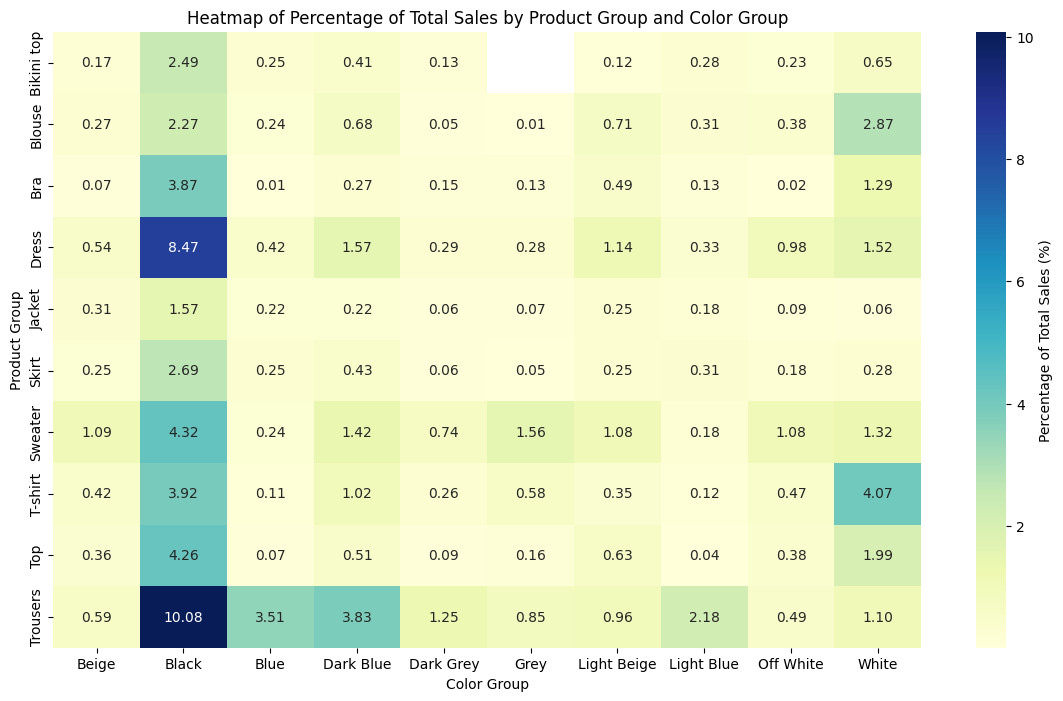

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'product_analysis' is your dataset

# Step 1: Calculate the total sales for each product group and each color group
total_sales_by_product_group = product_analysis.groupby('product_type_name')['total_sales'].sum().sort_values(ascending=False)
total_sales_by_color_group = product_analysis.groupby('colour_group_name')['total_sales'].sum().sort_values(ascending=False)

# Step 2: Get the top 10 best-selling product groups and color groups
top_10_product_groups = total_sales_by_product_group.head(10).index
top_10_color_groups = total_sales_by_color_group.head(10).index

# Step 3: Filter the data to include only these top 10 product and color groups
filtered_data = product_analysis[(product_analysis['product_type_name'].isin(top_10_product_groups)) & 
                                 (product_analysis['colour_group_name'].isin(top_10_color_groups))]

# Step 4: Create a pivot table for the filtered data
pivot_table = filtered_data.pivot_table(values='units_sold', index='product_type_name', columns='colour_group_name', aggfunc='sum')

# Step 5: Calculate the percentage of total sales for each combination
total_units_sold = filtered_data['units_sold'].sum()
pivot_table_percentage = pivot_table / total_units_sold * 100

# Step 6: Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table_percentage, annot=True, fmt=".2f", cmap='YlGnBu', cbar_kws={'label': 'Percentage of Total Sales (%)'})
plt.title('Heatmap of Percentage of Total Sales by Product Group and Color Group')
plt.xlabel('Color Group')
plt.ylabel('Product Group')

plt.show()



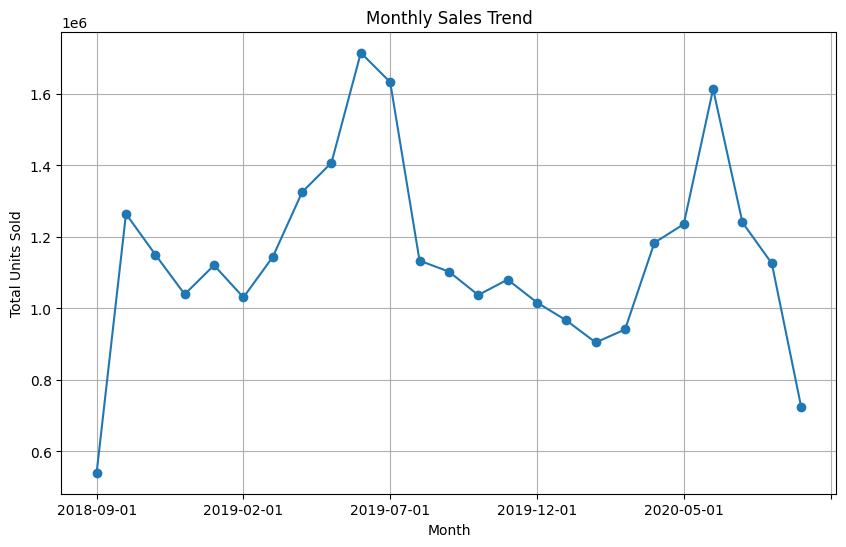

In [7]:

# Aggregate units sold by month
monthly_sales = product_analysis.groupby('month')['units_sold'].sum()

# Plotting the monthly sales trend
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='line', marker='o', linestyle='-')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Units Sold')
plt.grid(True)

plt.show()


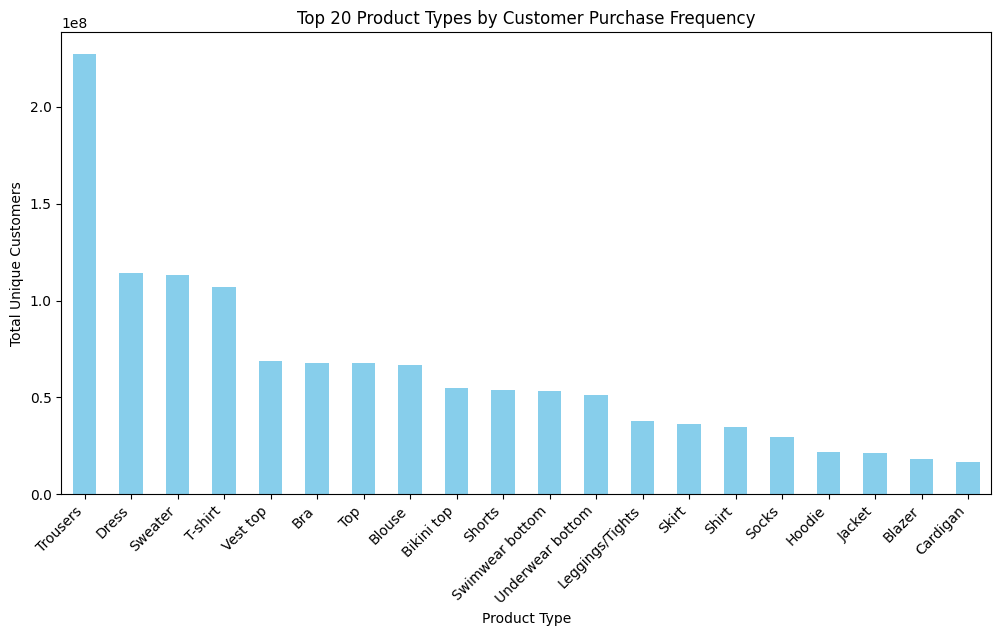

In [8]:
# Aggregate unique_customers by product type and select the top 20
customer_frequency_top20 = product_analysis.groupby('product_type_name')['unique_customers'].sum().sort_values(ascending=False).head(20)

# Plotting the top 20 product types by customer purchase frequency
plt.figure(figsize=(12, 6))
customer_frequency_top20.plot(kind='bar', color='skyblue')
plt.title('Top 20 Product Types by Customer Purchase Frequency')
plt.xlabel('Product Type')
plt.ylabel('Total Unique Customers')
plt.xticks(rotation=45, ha='right')

plt.show()



/var/folders/4d/qdk_qyjn1ng60t10crv82wj00000gn/T/ipykernel_24984/309251400.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_demand = filtered_data.groupby(['product_type_name', 'age_group'])['units_sold'].sum().unstack()


<Figure size 1400x800 with 0 Axes>

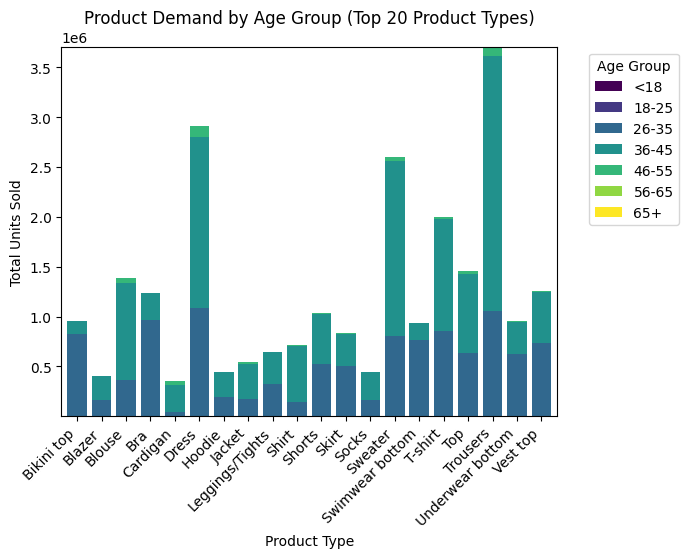

In [9]:
age_bins = [0, 18, 25, 35, 45, 55, 65, 100]
age_labels = ['<18', '18-25', '26-35', '36-45', '46-55', '56-65', '65+']
product_analysis['age_group'] = pd.cut(product_analysis['avg_customer_age'], bins=age_bins, labels=age_labels)

# Identify the top 20 product types by units sold
top20_product_types = product_analysis.groupby('product_type_name')['units_sold'].sum().sort_values(ascending=False).head(20).index

# Filter the data for only these top 20 product types
filtered_data = product_analysis[product_analysis['product_type_name'].isin(top20_product_types)]

# Aggregate units sold by product type and age group
age_demand = filtered_data.groupby(['product_type_name', 'age_group'])['units_sold'].sum().unstack()

# Plotting the stacked bar chart for the top 20 product types by age group
plt.figure(figsize=(14, 8))
age_demand.plot(kind='bar', stacked=True, colormap='viridis', width=0.8)
plt.title('Product Demand by Age Group (Top 20 Product Types)')
plt.xlabel('Product Type')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


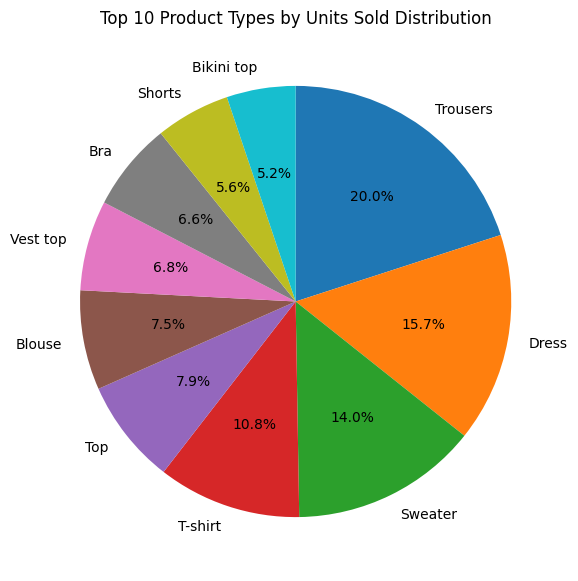

In [10]:
# Aggregate units sold by product type and select the top 10
top_product_distribution = product_analysis.groupby('product_type_name')['units_sold'].sum().sort_values(ascending=False).head(10)

# Plotting the distribution as a pie chart
plt.figure(figsize=(10, 7))
top_product_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Top 10 Product Types by Units Sold Distribution')
plt.ylabel('')  # Remove y-label for a cleaner look

plt.show()


/var/folders/4d/qdk_qyjn1ng60t10crv82wj00000gn/T/ipykernel_24984/3917448266.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_avg_units = product_analysis.groupby('product_type_name').apply(lambda x: x['units_sold'].sum() / x['unique_customers'].sum()).sort_values(ascending=False).head(10)


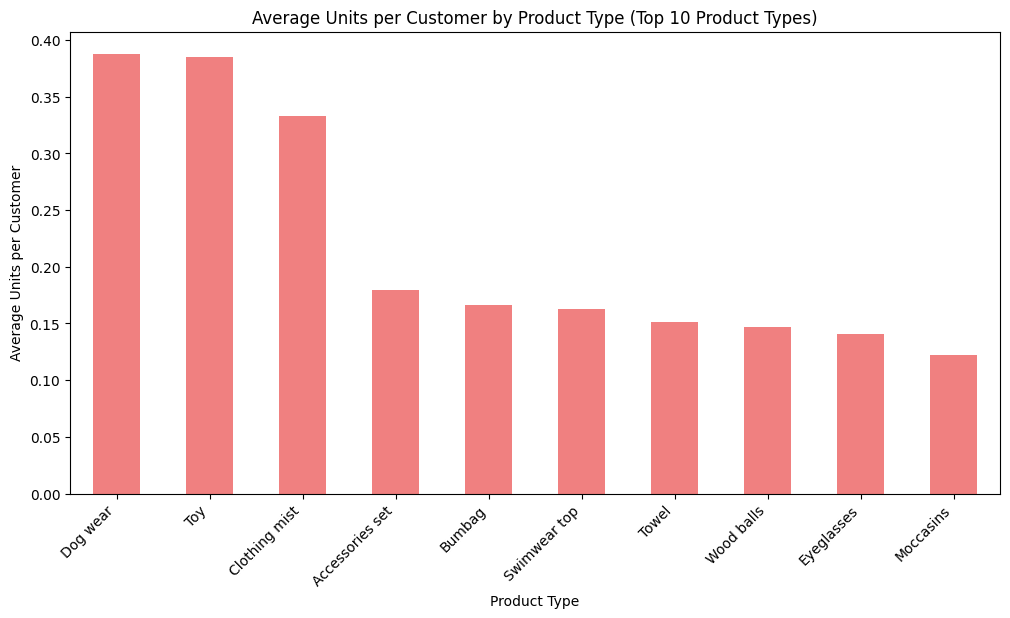

In [11]:
# Calculate average units per customer for each product type
product_avg_units = product_analysis.groupby('product_type_name').apply(lambda x: x['units_sold'].sum() / x['unique_customers'].sum()).sort_values(ascending=False).head(10)

# Plotting the bar chart
plt.figure(figsize=(12, 6))
product_avg_units.plot(kind='bar', color='lightcoral')
plt.title('Average Units per Customer by Product Type (Top 10 Product Types)')
plt.xlabel('Product Type')
plt.ylabel('Average Units per Customer')
plt.xticks(rotation=45, ha='right')

plt.show()

